# lorapy data processing

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
# from lorapy.io.load import DatLoader
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
OTA_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_OTA')
OUTDOOR_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_Outdoor')

## utils

In [4]:
import random
rand = lambda mx: random.randint(0, mx)

# load

In [5]:
loader = lorapy.load(OUTDOOR_DATA_DIR, autoload=True)
loader.filelist

2020-04-05 17:26:53.226 | DEBUG    | lorapy.io.load:_process_data_dir:73 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/LoRa_Recording_Outdoor
2020-04-05 17:26:53.229 | INFO     | lorapy.io.load:_process_data_dir:79 - found 20 datafile file(s)


[DatFile('lora_BW9_SF8_915MHz_1Msps_L42.dat'),
 DatFile('lora_BW8_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW2_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW8_SF11_915_25MHz_1Msps_L37.dat'),
 DatFile('lora_BW8_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW9_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW2_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW9_SF10_915MHz_1Msps_L1.dat'),
 DatFile('lora_BW1_SF12_915MHz_1Msps_Att70_v3.dat'),
 DatFile('lora_BW7_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW1_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW1_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW7_SF10_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW2_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW8_SF11_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW1_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW7_SF12_915MHz_1Msps_Att80_v0.dat'),
 DatFile('lora_BW1_SF8_914_75MHz_1Msps_L24.dat'),
 DatFile('lora_BW1_SF11_915MHz_1Msps_Att70_v3.dat'),
 DatFile('

In [6]:
for file in loader.filelist:
    break
    
file

DatFile('lora_BW9_SF8_915MHz_1Msps_L42.dat')

In [7]:
tar_filename = 'lora_BW9_SF10_915MHz_1Msps_L1.dat'

file = [file for file in loader.filelist if file.name == tar_filename][0]
file

DatFile('lora_BW9_SF10_915MHz_1Msps_L1.dat')

# process

## convert 

In [8]:
signal = file.to_signal()
signal

2020-04-05 17:26:53.348 | WARNING  | lorapy.utils.filename:extract_value:20 - no matches found [Att(\d{1,})] in filename lora_BW9_SF10_915MHz_1Msps_L1.dat | None
2020-04-05 17:26:53.354 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 2048 and packet length: 61952
2020-04-05 17:26:53.593 | INFO     | lorapy.datafile.file:load:31 - loaded 56343771 samples from file


LoraSignal(length=56343771) | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 2048 | packet length: 61952

## stats 

In [9]:
signal.stats

BW: 9 | SF: 10 | Att: 0 | samples per symbol: 2048 | packet length: 61952

## plots

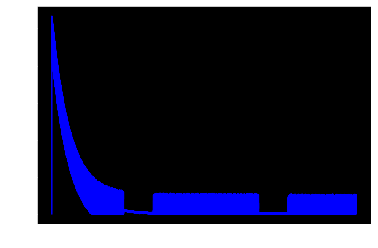

In [10]:
signal.plot(real=True, stop=180_000, color='blue')

# packets

## extract - auto adjust

## extract - manual adjust

In [11]:
signal.extract_packets(method='slide-mean', auto_adj=False, overlap=0.7)

2020-04-05 17:26:54.008 | INFO     | lorapy.signals.signal:_process_signal:106 - selected "slide-mean" processing method
2020-04-05 17:26:54.176 | INFO     | lorapy.signals.processing.sliding_mean:_find_all_mindices:55 - scanning signal for padding locations..
2020-04-05 17:26:54.177 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 0
2020-04-05 17:26:54.193 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 100
2020-04-05 17:26:54.208 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 200
2020-04-05 17:26:54.225 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 300
2020-04-05 17:26:54.243 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 400
2020-04-05 17:26:54.263 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 500
2020-04-05 17:26:54.282 | DEBUG    | lorapy.signals.proce

In [12]:
signal.adjust_packets(force_check=True, look_ahead=100, threshold=0.5)

2020-04-05 17:27:07.125 | DEBUG    | lorapy.signals.signal:_adjust_endpoints:86 - adjusted endpoints
2020-04-05 17:27:07.126 | DEBUG    | lorapy.packets.utils:slice_all_packets:21 - got max packet length: 61952
2020-04-05 17:27:07.375 | INFO     | lorapy.packets.utils:slice_all_packets:28 - extracted 908 packets from signal
2020-04-05 17:27:07.408 | DEBUG    | lorapy.signals.signal:_slice_and_load:62 - loaded 908 lora packets


/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


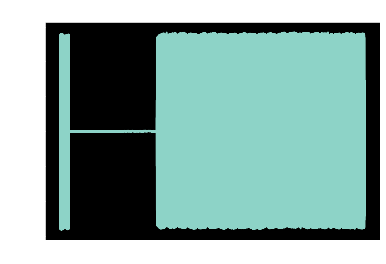

In [13]:
signal.plot_packet(real=False)

## inspect

In [14]:
for packet in signal.packets[:14]:
    pass
    
packet

LoraPacket(id=13) || size: 61952 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 2048 | packet length: 61952

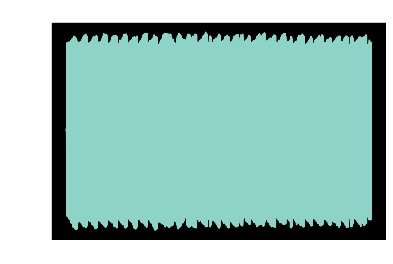

In [15]:
packet.plot(real=False)

# symbols

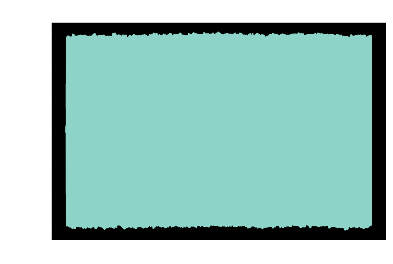

LoraPacket(id=445) || size: 61952 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 2048 | packet length: 61952

In [69]:
packet = signal.random_packet
packet.plot()
display(packet)

## extraction

In [70]:
packet.extract_preamble_symbols()

2020-04-05 17:36:09.575 | DEBUG    | lorapy.symbols.utils:slice_preamble_symbols:26 - extracted 8 symbols with length 2048
2020-04-05 17:36:09.576 | DEBUG    | lorapy.packets.packet:_slice_and_load:113 - loaded 8 lora symbols


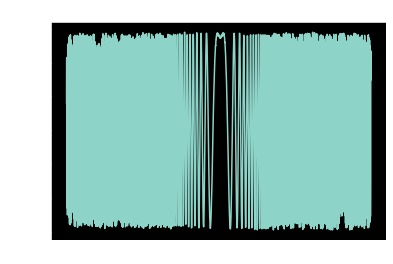

In [71]:
packet.plot_symbol(real=False)

## inspection

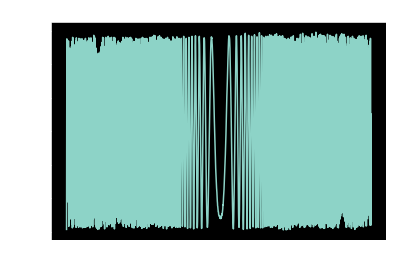

LoraSymbol(id=4) || size: 2048 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 2048 | packet length: 61952

In [80]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

## convolution

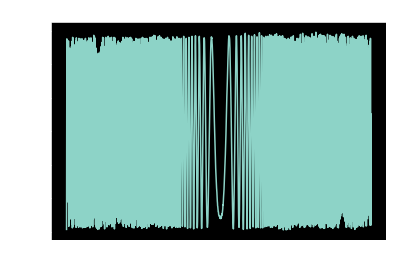

In [81]:
symbol.plot()

### setup `.p` reference

In [47]:
loader = lorapy.load(OUTDOOR_DATA_DIR, autoload=False, glob_pattern='**/*BW9*.p')
p_file_path = loader.filepath
p_file_path

2020-04-05 17:34:08.274 | DEBUG    | lorapy.io.load:_process_data_dir:73 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/LoRa_Recording_Outdoor
2020-04-05 17:34:08.276 | INFO     | lorapy.io.load:_process_data_dir:79 - found 1 datafile file(s)


PosixPath('/Users/trevor/Work/1-projects/lora-processing/data/LoRa_Recording_Outdoor/lora_symbols_BW9_SF10.p')

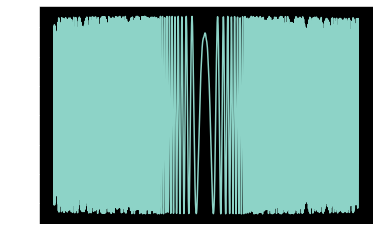

In [48]:
from six.moves import cPickle
with p_file_path.open('rb') as pfile:
    baseline = cPickle.load(pfile)

baseline = baseline[1,:]
plt.plot(np.real(baseline))

## convolve - builtin

In [82]:
symbol.convolve(baseline)

2020-04-05 17:38:05.713 | DEBUG    | lorapy.symbols.symbol:convolve:37 - convolved symbol with baseline: 52.70575033960172


52.70575033960172

## signal all together

2020-04-05 17:43:46.015 | DEBUG    | lorapy.symbols.utils:slice_preamble_symbols:26 - extracted 8 symbols with length 2048
2020-04-05 17:43:46.016 | DEBUG    | lorapy.packets.packet:_slice_and_load:113 - loaded 8 lora symbols


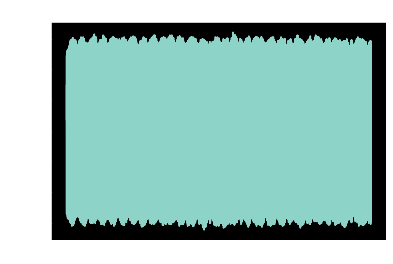

LoraPacket(id=248) || size: 61952 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 2048 | packet length: 61952

In [91]:
packet = signal.random_packet
packet.extract_preamble_symbols()

packet.plot()
display(packet)

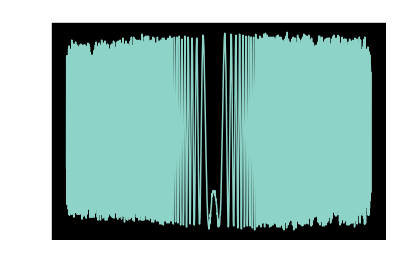

LoraSymbol(id=5) || size: 2048 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 2048 | packet length: 61952

In [92]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

In [93]:
symbol.convolve(baseline)

2020-04-05 17:44:00.164 | DEBUG    | lorapy.symbols.symbol:convolve:37 - convolved symbol with baseline: 108.2264807525887


108.2264807525887

In [97]:
symbol.absolute_endpoints

(15472924, 15474972)

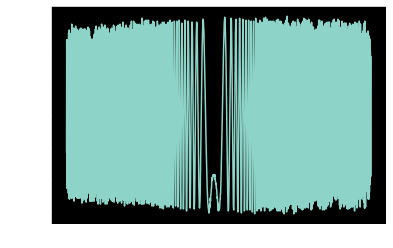

In [95]:
signal.plot(real=False, start=symbol.absolute_endpoints[0], stop=symbol.absolute_endpoints[1])

In [96]:
signal.stats.filename

'lora_BW9_SF10_915MHz_1Msps_L1.dat'

## conv scratch

In [ ]:
baseline = baseline[0:signal.stats.samp_per_sym]

c_out = []

for i in range(symbols.shape[0]):
    sig = symbols[i,:]
    sig_c = np.conj(sig[::-1])
    conv_val = np.abs(np.convolve(baseline,sig_c))/np.linalg.norm(sig)/np.linalg.norm(sig)

    c_out.append(np.max(conv_val))

fig = plt.figure(figsize=(15,5))
plt.plot(c_out)